# Vehicle Detection

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

## Pipeline

### Imports

In [1]:
import collections

import cv2

from IPython.display import HTML

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage.measurements import label

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

import os
%matplotlib inline

### Load Image

In [2]:
def locate_images(dirpath):
    imgs = []
    for root, _, filenames in os.walk(dirpath):
        for name in filenames:
            if not name.endswith(('.jpg', '.png')):
                continue
            filepath = os.path.join(root, name)
            imgs.append(filepath)
    return imgs

### Test Random Image

./data/vehicles/GTI_Far/image0004.png
./data/non-vehicles/Extras/extra1.png


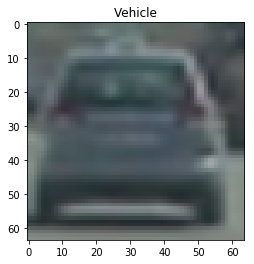

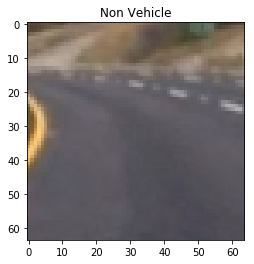

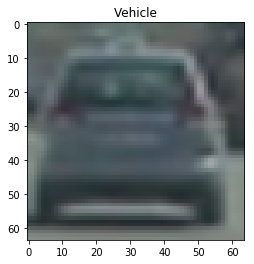

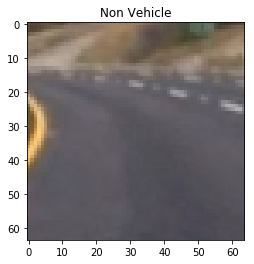

In [3]:
vehicle_imgs = locate_images('./data/vehicles/')
non_vehicle_imgs = locate_images('./data/non-vehicles/')
print (vehicle_imgs[4])
print (non_vehicle_imgs[0])
vehicle_img = mpimg.imread(vehicle_imgs[4])
non_vehicle_img = mpimg.imread(non_vehicle_imgs[4])
plt.imshow(vehicle_img)
plt.title('Vehicle')
plt.show()
plt.imshow(non_vehicle_img)
plt.title('Non Vehicle')
plt.show()
vehicle_img = (vehicle_img * 255).astype(np.uint8)
non_vehicle_img = (non_vehicle_img * 255).astype(np.uint8)
plt.imshow(vehicle_img)
plt.title('Vehicle')
plt.show()
plt.imshow(non_vehicle_img)
plt.title('Non Vehicle')
plt.show()

### Transform Image

Convert the image to YCrCb format.

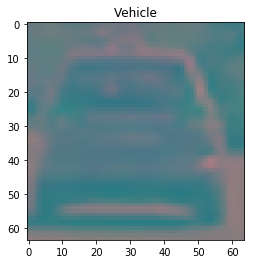

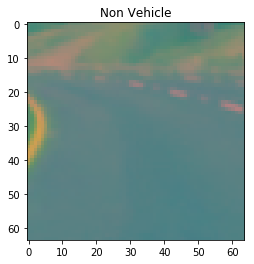

In [4]:
vehicle_img = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2YCrCb)
non_vehicle_img = cv2.cvtColor(non_vehicle_img, cv2.COLOR_RGB2YCrCb)
plt.imshow(vehicle_img)
plt.title('Vehicle')
plt.show()
plt.imshow(non_vehicle_img)
plt.title('Non Vehicle')
plt.show()

### Spatial Binning of Image

In [5]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

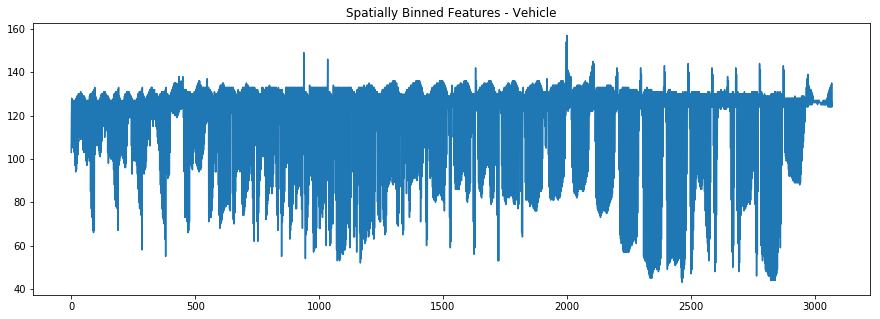

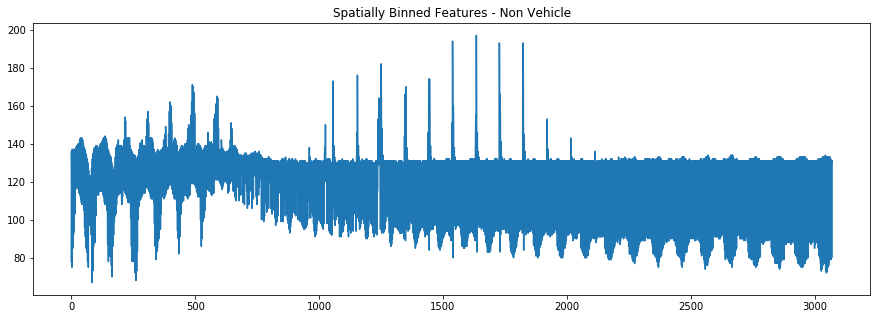

In [6]:
vehicle_bin = bin_spatial(vehicle_img)
non_vehicle_bin = bin_spatial(non_vehicle_img)
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(vehicle_bin)
plt.title('Spatially Binned Features - Vehicle')
plt.show()
plt.plot(non_vehicle_bin)
plt.title('Spatially Binned Features - Non Vehicle')
plt.show()

### Color Histogram of image

Concatenation of all channels of image.

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

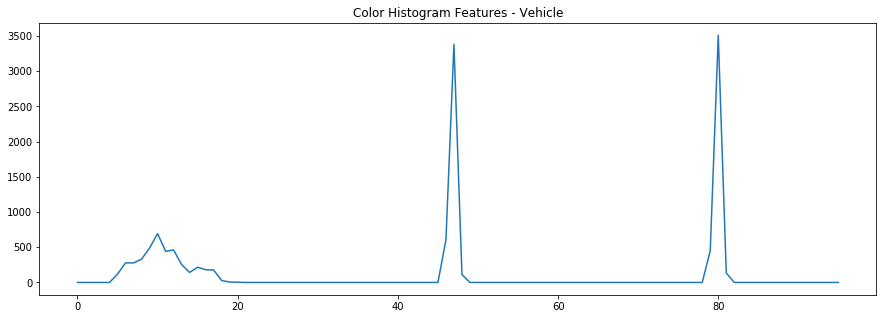

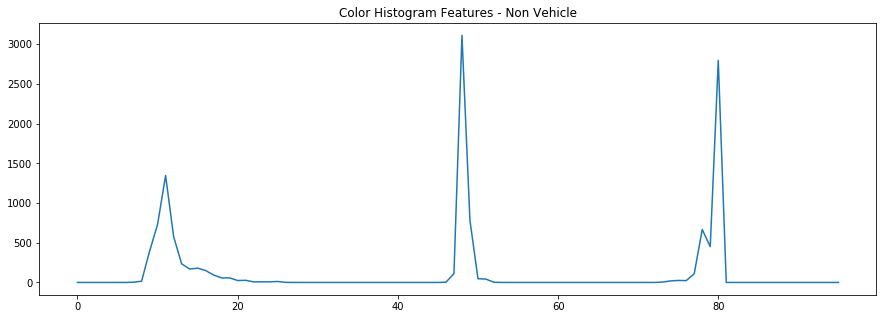

In [8]:
vehicle_color_hist = color_hist(vehicle_img)
non_vehicle_color_hist = color_hist(non_vehicle_img)
plt.plot(vehicle_color_hist)
plt.title('Color Histogram Features - Vehicle')
plt.show()
plt.plot(non_vehicle_color_hist)
plt.title('Color Histogram Features - Non Vehicle')
plt.show()

### HOG features of the image

In [9]:
def get_hog_features(img, pix_per_cell=8, cell_per_block=2, orient=9, hog_channel='ALL', vis=True):
    hog_features = []
    hog_images = []
    for channel in range(img.shape[2]):
        if vis:
            hog_feature, hog_image = hog(img[:,:,channel], orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block),
                      visualise=vis, feature_vector=True)
            hog_features.append(hog_feature)
            hog_images.append(hog_image)
        else:
            hog_feature = hog(img[:,:,channel], orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block),
                      visualise=vis, feature_vector=True)
            hog_features.append(hog_feature)
    hog_features = np.ravel(hog_features)
    if vis:
        return hog_features, hog_images
    else:
        return hog_features

/Users/dhirendra/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


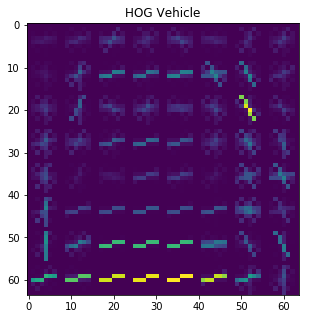

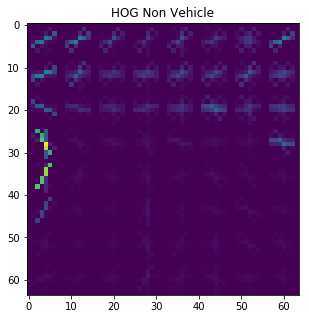

In [10]:
vehicle_hog_features, vehicle_hog_images = get_hog_features(vehicle_img)
plt.imshow(vehicle_hog_images[0])
plt.title("HOG Vehicle")
plt.show()
non_vehicle_hog_features, non_vehicle_hog_images = get_hog_features(non_vehicle_img)
plt.imshow(non_vehicle_hog_images[0])
plt.title("HOG Non Vehicle")
plt.show()

### Extract & Combine features
1. Spatial Binning
2. Color Histogram
3. HOG features
4. Concatenate the features extracted.

In [11]:
def extract_feature(img, cspace='YCrCb', spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), pix_per_cell=8, cell_per_block=2, 
                    orient=9, hog_channel='ALL'):
    """Given an image returns a 1D feature vector using spatial binning,
    color histogram and hog features."""
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      

    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    hog_features = get_hog_features(feature_image, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    orient=orient, hog_channel=hog_channel, vis=False)

    features = np.concatenate((spatial_features, hist_features, hog_features))
    return features

/Users/dhirendra/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


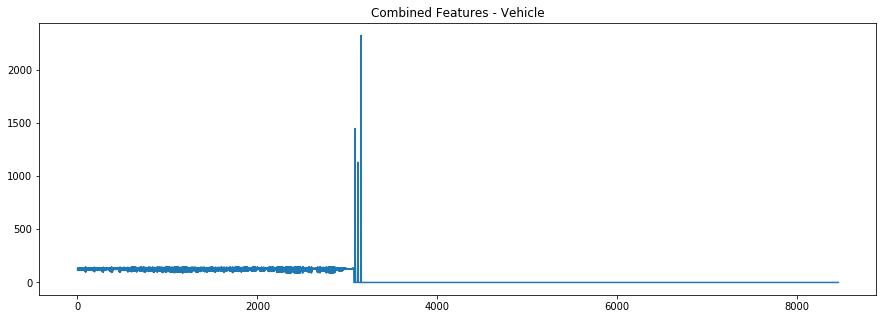

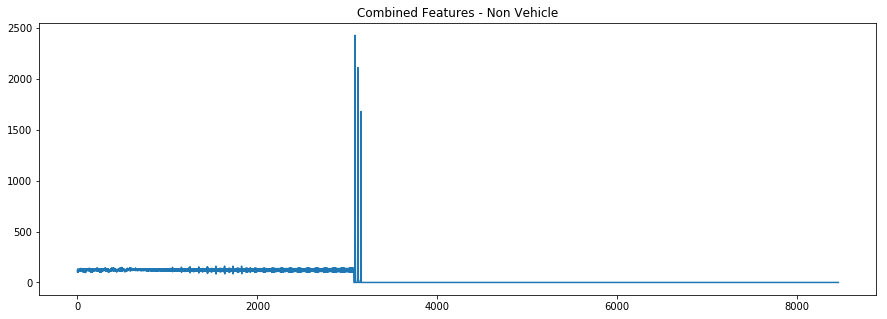

In [12]:
vehicle_combined = extract_feature(vehicle_img)
non_vehicle_combined = extract_feature(non_vehicle_img)
plt.plot(vehicle_combined)
plt.title('Combined Features - Vehicle')
plt.show()
plt.plot(non_vehicle_combined)
plt.title('Combined Features - Non Vehicle')
plt.show()

### Feature extraction of images

In [13]:
def extract_features(img_paths, *args, **kwargs):
    """Given a list of image filenames, returns a list of features. This function
    is for generating the initial training data."""
    features = []
    for filename in img_paths:
        img = mpimg.imread(filename)
        # matplotlib imread scales png images from 0-1 and jpeg from 0-255
        if filename.endswith('.png'):
            img = (img * 255).astype(np.uint8)

        # img = cv2.resize(img, IMAGE_SIZE)
        features.append(extract_feature(img, *args, **kwargs))
    return features

### Model

Here basically I'm using a SVM classifier. I experimented with multiple orientation, pixels_per_cell, cell_per_block. Wiht various combinations my models accuracy was:

Color Space  |  Orient  | pix_per_cell | cell_per_block | accuracy
:-----------:|:--------:|:------------:|:--------------:|:-----------:
YUV | 9 | 8 | 2 | 97%
YUV | 8 | 8 | 2 | 98%
RGB | 9 | 8 | 2 | 97%
RGB | 8 | 8 | 2 | 98%
YCrCb | 9 | 8 | 2 | 99%
YCrCb | 8 | 8 | 2 | 98%
YCrCb | 7 | 8 | 2 | 98%

However, the accuracy was already very high with default parameters and out of the 
box linear SVM so I did not feel compelled to explore that much more. I ended up just using `YCrCb`, `orient=9`, `pix_per_cell=8`, and `cell_per_block=2`. 


In [14]:
def train_model():
    """Generates training and validation data and then trains and returns
    a linear SVM model.""" 
    vehicles = locate_images('./data/vehicles/')
    non_vehicles = locate_images('./data/non-vehicles/')
    print(len(vehicles), len(non_vehicles))

    X = np.vstack((
            extract_features(vehicles),
            extract_features(non_vehicles)
        )).astype(np.float64)
    scaler = StandardScaler().fit(X)
    scaled_X = scaler.transform(X)
    del X
    y = np.hstack((
            np.ones(len(vehicles)), 
            np.zeros(len(non_vehicles))
        ))


    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

    svc = svm.LinearSVC()
    svc.fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    print('Test Accuracy:', accuracy)
    
    return {'model': svc, 'scaler': scaler, 'test_accuracy': accuracy}

## Video Pipeline

In [15]:
class VehicleDetector(object):

    # image size of each frame in the video
    IMAGE_SIZE = (720, 1280)

    # how many previous frames to keep track of for accumulating heatmaps
    ROLLING_FRAME_WINDOW = 4

    def __init__(self, svm_classifier, scaler):
        self.svm_classifer = svm_classifier
        self.scaler = scaler
        self.windows = self.generate_windows(img_shape=self.IMAGE_SIZE)

        self.frame_counter = 0
        self.prior_heatmaps = collections.deque(maxlen=self.ROLLING_FRAME_WINDOW)

    def draw(self, img):
        """Draw bounding boxes onto the frame of the video. This is the 
        main method called when video processing."""
        self.frame_counter += 1
        hot_windows = self.search_windows(img, self.windows)
        heatmap = self.generate_heatmap(img, hot_windows)
        labels = label(heatmap)

        return self._draw_bboxes(img, labels)

    def _draw_bboxes(self, img, labels):
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        return img

    def slide_window(self, img_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img_shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img_shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list

    def generate_windows(self, img_shape):
        """Generates a list of windows at three different scales: 64x64, 128x128,
        and 160x160."""
        windows = []
        windows += self.slide_window(img_shape, x_start_stop=[400,None], y_start_stop=[325,600], xy_overlap=(0.75, 0.75))
        windows += self.slide_window(img_shape, x_start_stop=[400,None], y_start_stop=[325,680], 
                               xy_window=(128,128), xy_overlap=(0.75, 0.75))
        windows += self.slide_window(img_shape, x_start_stop=[400,None], y_start_stop=[325,680], 
                               xy_window=(160,160), xy_overlap=(0.8, 0.8))
        return windows

    def search_windows(self, img, windows):
        """Use SVM model to return a subset of windows that contain potential
        vehicles."""
        positive_windows = []

        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            features = extract_feature(test_img)

            X = self.scaler.transform(np.array(features).reshape(1, -1))
            prediction = self.svm_classifer.predict(X)

            if prediction == 1:
                positive_windows.append(window)
        return positive_windows

    def generate_heatmap(self, img, windows, threshold=10):
        """Returns a heatmap of vehicle detections. Heatmap is accumulated 
        over past N frames and thresholded to remove false positives."""
        heatmap = np.zeros_like(img[:, :, 0])
        for window in windows:
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1

        self.prior_heatmaps.append(heatmap)


        cumulative_heatmap = np.sum(self.prior_heatmaps, axis=0)
        if threshold:
            cumulative_heatmap[cumulative_heatmap <= threshold] = 0

        return cumulative_heatmap


### Test Pipeline on test images

In [16]:
print('Training Model')
svc = train_model()
model = svc['model']
scaler = svc['scaler']
print('Training Finished.')

Training Model
8792 8968


/Users/dhirendra/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy: 0.992117117117
Training Finished.


### Create output video

In [17]:
def create_video(svm_model, scaler, input_file='./test_video.mp4',
                 output_file='./test_output.mp4'):
    from moviepy.editor import VideoFileClip

    vd = VehicleDetector(svm_model, scaler)
    clip = VideoFileClip(input_file)
    out_clip = clip.fl_image(vd.draw) 
    out_clip.write_videofile(output_file, audio=False)

    return vd

### Run Pipeline

In [18]:
input_file = './project_video.mp4'
output_file = './project_output_video.mp4'
video = create_video(model, scaler, input_file, output_file)

[MoviePy] >>>> Building video ./project_output_video.mp4
[MoviePy] Writing video ./project_output_video.mp4


100%|█████████▉| 1260/1261 [1:27:51<00:03,  3.93s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output_video.mp4 



In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))